Gerekli Kütüphanelerin ve veri Setinin Yüklenmesi

In [2]:
# Kütüphaneler
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Veri Setinin Yüklenmesi (Colab)
file_path = '/content/tunnel_risk_dataset.csv'  # Dosya yolunun doğru girildiğinden emin olun
data = pd.read_csv(file_path)

Verinin Temizlenmesi

In [3]:
# Adım 1: Veri Temizliği
print("Verinin ilk hali:", data.shape)

# Veri setinin nezdinde ilk sütunun tünel kimlikleri olması hasebiyle devre dışı bırakılması
data = data.iloc[:, 1:]

# Boş hücrelerin kontrolü ve kaldırılması
print("\nNull değer kontrolü:")
print(data.isnull().sum())
data = data.dropna()
print("\nVerinin temizlenmiş hali:", data.shape)

Verinin ilk hali: (1000, 8)

Null değer kontrolü:
Length (m)           0
Depth (m)            0
Rock_Type            0
Water_Level          0
Displacement (mm)    0
Settlement (mm)      0
Risk_Level           0
dtype: int64

Verinin temizlenmiş hali: (1000, 7)


Sınıfsal Değerlerin Manipülasyonu

In [4]:
# Adım 2: Kategorik değişkenlerin düzenlenmesi
# Kategorik sütunların tespiti
categorical_columns = data.select_dtypes(include=['object']).columns
print("\nSınıfsal Değer İçeren Sütunlar (Özellikler):", categorical_columns.tolist())

# Her kategorik sütundaki eşsiz değerlerin tespiti
print("\nKategorik sütunlardaki eşsiz değer sayıları:")
print(data[categorical_columns].nunique())

# Nadir sıklıktaki değerlerin "Other" sütununa atanması
threshold = 10  # Nadir kategorileri ayıklamak için threshold değeri belirleme
for col in categorical_columns:
    if data[col].nunique() > threshold:
        top_categories = data[col].value_counts().nlargest(threshold).index
        data[col] = data[col].apply(lambda x: x if x in top_categories else 'Other')

# Kategorik sütunların dummy özelliklere dönüştürülmesi (encoding)
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)
print("\nKategorik sütunların dönüşümü sonrası veri setinin şekli:", data.shape)


Sınıfsal Değer İçeren Sütunlar (Özellikler): ['Rock_Type', 'Water_Level']

Kategorik sütunlardaki eşsiz değer sayıları:
Rock_Type      4
Water_Level    3
dtype: int64

Kategorik sütunların dönüşümü sonrası veri setinin şekli: (1000, 10)


Korelasyon Analizi

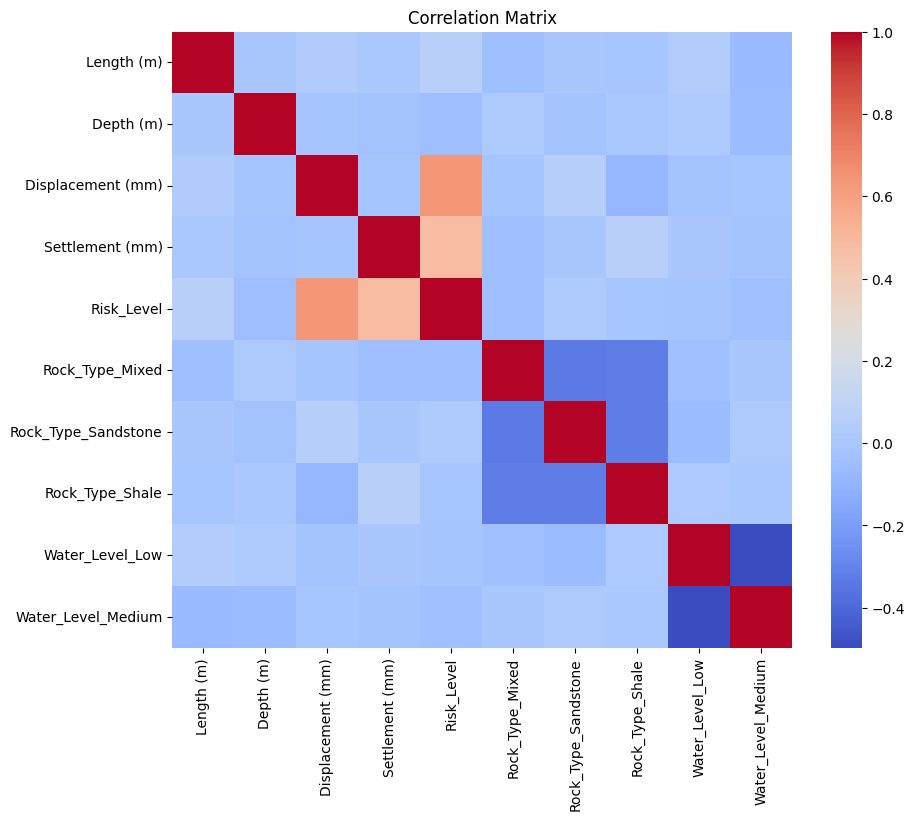

In [5]:
# Adım 3: Korelasyon Matrisi
plt.figure(figsize=(10, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [7]:
# Adım 4: En yüksek korelasyona sahip özelliklerin belirlenmesi
# Hedef sütunun verinin geri kalanından ayrılması
X = data.drop(columns=['Risk_Level'])
y = data['Risk_Level']

# Hedef sütuna en korele özelliklerin tespiti
correlations = correlation_matrix['Risk_Level'].drop('Risk_Level').sort_values(ascending=False)
print("\nRisk_Level sütunu ile en korele özellikler:")
print(correlations.head())


Risk_Level sütunu ile en korele özellikler:
Displacement (mm)      0.635222
Settlement (mm)        0.482426
Length (m)             0.061035
Rock_Type_Sandstone    0.024984
Rock_Type_Shale       -0.008762
Name: Risk_Level, dtype: float64


Modellerin Eğitimi ve Performans Analizleri

In [8]:
# Adım 5: Eğitim ve test veri setlerinin oluşturulması
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
# Adım 6: Veri değerlerinin standardize edilmesi
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
# Adım 7: Modellerin eğitilmesi ve performans kıyaslamaları
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Support Vector Machine': SVC(probability=True, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

results = {}

for model_name, model in models.items():
    print(f"Model eğitiliyor: {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[model_name] = accuracy
    print(f"{model_name} modeli için doğruluk oranı: {accuracy:.2f}\n")

Model eğitiliyor: Random Forest...
Random Forest modeli için doğruluk oranı: 0.99

Model eğitiliyor: Support Vector Machine...
Support Vector Machine modeli için doğruluk oranı: 0.83

Model eğitiliyor: K-Nearest Neighbors...
K-Nearest Neighbors modeli için doğruluk oranı: 0.73



In [12]:
# Adım 8: En iyi modelin seçilmesi
best_model_name = max(results, key=results.get)
print(f"En iyi çalışan model: {best_model_name}, doğruluk oranı: {results[best_model_name]:.2f}")

En iyi çalışan model: Random Forest, doğruluk oranı: 0.99


Seçilen Modelin Performans Metrikleri


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.97      1.00      0.98        28
           2       1.00      1.00      1.00        44
           3       1.00      1.00      1.00       121

    accuracy                           0.99       200
   macro avg       0.99      0.96      0.98       200
weighted avg       1.00      0.99      0.99       200


Confusion Matrix:


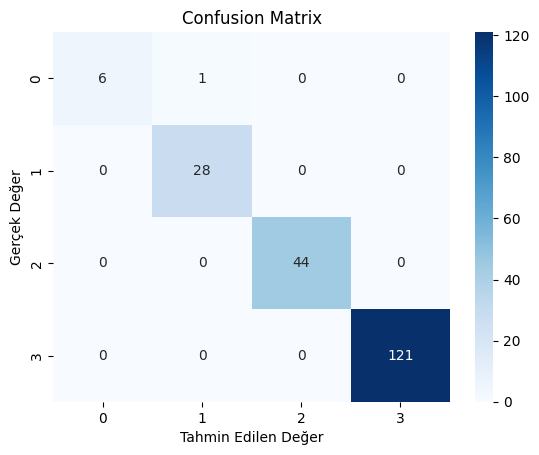

In [13]:
# Adım 9: Seçilen modelin performans metrikleri
best_model = models[best_model_name]
y_pred = best_model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Tahmin Edilen Değer')
plt.ylabel('Gerçek Değer')
plt.show()